In [155]:
import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)


ae_dir = os.path.join(project_dir, 'modules/AutoEncoder')
if ae_dir not in sys.path:
    sys.path.append(ae_dir)

ipdl_dir = os.path.join(project_dir, 'modules/IPDL')
if ipdl_dir not in sys.path:
    sys.path.append(ipdl_dir)

import torch
from torch import nn
from torch.distributions import MultivariateNormal
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter


from autoencoder import SDAE, SDAE_TYPE

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Adversarial AutoEncoder architecture

In [156]:
z_dim = 32
sdae = SDAE([28*28, 1024, 1024, z_dim], SDAE_TYPE.linear, dropout=False, 
            activation_func=[nn.ReLU(), nn.ReLU(), nn.Identity()])

In [157]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        r'''
            Parameters
            ----------
                input_dim: int
                    Indicate the dimensionality of latent space Z

                hidden_dim: int
        '''
        super(Discriminator, self).__init__()
        self.D = nn.Sequential(*[
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(p=.2),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),
        ])  
    def forward(self, x):
        return self.D(x)

In [158]:
# Encoder
Q = sdae.encode.to(device)

# Decoder
P = sdae.decode.to(device)

# Discriminator
D = Discriminator(z_dim, 512).to(device)

# Dataset
## Train

In [159]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Subset, DataLoader

dataset_full = MNIST('data/', train = True, download = True, transform = transforms.ToTensor())
# idx = torch.where((dataset_full.targets == 0) | (dataset_full.targets == 2))[0]
normal_idx = torch.where((dataset_full.targets == 0))[0]
anomaly_idx = torch.where((dataset_full.targets == 2))[0]
idx = torch.cat([normal_idx, anomaly_idx[:512]])

x_train_set = Subset(dataset_full, idx)
train_loader =  DataLoader(x_train_set, 128, shuffle=True)

tensor(0)


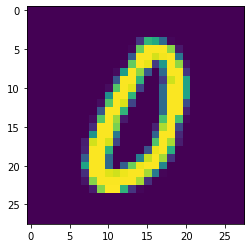

In [160]:
# TO REMOVE! Just testing!
x, y = next(iter(train_loader))
plt.imshow(x[0,0])
print(y[0])

## Test

In [161]:
test_dataset_full = MNIST('data/', train=False, download=True, transform = transforms.ToTensor())
idx_0 = torch.where(test_dataset_full.targets == 0)[0]
idx_2 = torch.where(test_dataset_full.targets == 2)[0]

test_dataset_0 = Subset(test_dataset_full, idx_0)
test_dataset_2 = Subset(test_dataset_full, idx_2)
test_loader_0 =  DataLoader(test_dataset_0, 512, shuffle=False)
test_loader_2 =  DataLoader(test_dataset_2, 512, shuffle=False)

## Defining 2-Dimensional Guassian as prior
$p(z) \sim \mathcal{N}_n(\mu, \sum)$

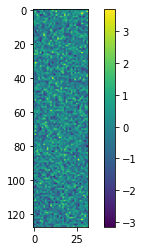

In [162]:
prior = MultivariateNormal(loc=torch.zeros(z_dim), covariance_matrix=torch.eye(z_dim))

plt.imshow(prior.sample((128,)))
plt.colorbar()
plt.show()

# Training

In [164]:
# Set learning rates
gen_lr = 1e-3
reg_lr = 5e-4

#encode/decode optimizers
optim_P = torch.optim.Adam(P.parameters(), lr=gen_lr)
optim_Q_enc = torch.optim.Adam(Q.parameters(), lr=gen_lr)
#regularizing optimizers
optim_Q_gen = torch.optim.Adam(Q.parameters(), lr=reg_lr)
optim_D = torch.optim.Adam(D.parameters(), lr=reg_lr)

In [352]:
n_epoch = 240
recons_criterion = nn.MSELoss()
# recons_criterion = nn.BCELoss()
eps = 1e-12
tb_writer = SummaryWriter('log/AAE_Refinement_3')

for epoch in range(n_epoch):
    recons_loss_ = []
    disc_loss_ = []
    gen_loss_ = []
    Q.train()
    P.train()
    for idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.flatten(1)
        optim_P.zero_grad()
        optim_Q_enc.zero_grad()
        optim_Q_gen.zero_grad()
        optim_D.zero_grad()

        # Reconstruction loss
        z = Q(inputs)
        out = P(z)

        recon_loss = recons_criterion(out, inputs)
        recons_loss_.append(recon_loss.item())

        recon_loss.backward()
        optim_P.step()
        optim_Q_enc.step()

        # Discriminator
        # Prior as an multivariate gaussian function $p(z) \sim \mathcal{N}_n(\mu, \sum)$
        # this is constraining the Z-projection to be normal!
        Q.eval()
        z_real_gauss = prior.sample((inputs.size(0),)).to(device)
        D_real_gauss = D(z_real_gauss)

        z_fake_gauss = Q(inputs)
        D_fake_gauss = D(z_fake_gauss)

        D_loss = -torch.mean(torch.log(D_real_gauss + eps) + torch.log(1 - D_fake_gauss + eps))
        disc_loss_.append(D_loss.item())

        D_loss.backward()
        optim_D.step()

        # Generator
        Q.train()
        z_fake_gauss = Q(inputs)
        D_fake_gauss = D(z_fake_gauss)
        
        G_loss = -torch.mean(torch.log(D_fake_gauss + eps))
        gen_loss_.append(G_loss.item())

        G_loss.backward()
        optim_Q_gen.step()

    tb_writer.add_scalar('train/reconstruction', np.array(recons_loss_).mean(), epoch)
    tb_writer.add_scalar('train/Discrimator', np.array(disc_loss_).mean(), epoch)
    tb_writer.add_scalar('train/Generator', np.array(gen_loss_).mean(), epoch)
    
    Q.eval()
    P.eval()
    with torch.no_grad():
        loss_0 = []
        loss_2 = []
        for inputs, _ in test_loader_0:
            inputs = inputs.to(device).flatten(1)
            z = Q(inputs)
            out = P(z)
            
            loss_0.append(recons_criterion(out, inputs).item())

        for inputs, _ in test_loader_2:
            inputs = inputs.to(device).flatten(1)
            z = Q(inputs)
            out = P(z)
            
            loss_2.append(recons_criterion(out, inputs).item())
        

        tb_writer.add_scalar('test/reconstruction/0', np.array(loss_0).mean(), epoch)
        tb_writer.add_scalar('test/reconstruction/2',np.array(loss_2).mean(), epoch)

In [353]:
z = Q(inputs)
out = P(z)

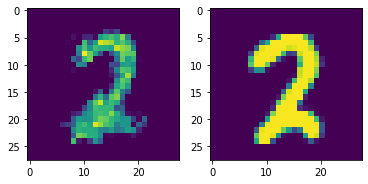

In [354]:
idx = np.random.randint(0, len(inputs)-1)
test_in = inputs[idx].reshape(28,28)
test_out = out[idx].reshape(28,28)

plt.subplot(1,2,1)
plt.imshow(test_out.cpu().detach())
plt.subplot(1,2,2)
plt.imshow(test_in.cpu().detach())
plt.show()

# Anomaly Detection

In [355]:
from sklearn.neighbors import KernelDensity

loader = DataLoader(x_train_set, 2048, shuffle=True)
x, y = next(iter(loader))
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(x.flatten(1))

In [356]:
def cal_density_and_recon_error(loader:DataLoader, Q:nn.Module, P:nn.Module, kde: KernelDensity) -> tuple:
    density = None
    recon_error_list = []
    recon_criterion = nn.MSELoss()
    Q.eval()
    P.eval()
    for inputs, _ in loader:
        inputs = inputs.flatten(1).to(device)
        z = Q(inputs)
        reconstruction = P(z)
        recon_error_list.append(recon_criterion(reconstruction, inputs).cpu().item())

        if density is None:
            density = kde.score_samples(inputs.cpu())
        else:
            density = np.concatenate((density, kde.score_samples(inputs.cpu())))

    average_density = density.mean()
    stdev_density = density.std()

    average_recon_error = np.array(recon_error_list).mean()
    stdev_recon_error = np.array(recon_error_list).std()

    return (average_density, stdev_density, average_recon_error, stdev_recon_error)

In [357]:
idx_train_0 = torch.where((dataset_full.targets == 0))[0]
idx_train_2 = torch.where((dataset_full.targets == 2))[0]

x_train_0 = Subset(dataset_full, idx_train_0)
x_train_2 = Subset(dataset_full, idx_train_2)
train_loader_0 = DataLoader(x_train_0, 2048, shuffle=False)
train_loader_2 = DataLoader(x_train_2, 2048, shuffle=False)

average_density_0, stdev_density_0, average_recon_error_0, stdev_recon_error_0 = cal_density_and_recon_error(train_loader_0, Q, P, kde)
print(average_density_0, stdev_density_0, average_recon_error_0, stdev_recon_error_0)
average_density_2, stdev_density_2, average_recon_error_2, stdev_recon_error_2 = cal_density_and_recon_error(train_loader_2, Q, P, kde)
print(average_density_2, stdev_density_2, average_recon_error_2, stdev_recon_error_2)

428.5163372046552 140.70466900388593 0.004607710521668196 3.2047163200105793e-05
239.80037437816983 288.5157324550274 0.0358224684993426 0.0006878225159841191


In [359]:
# density_threshold =  average_density_0 - (average_density_0 - average_density_2)/2 
reconstruction_error_threshold = 0.03
density_threshold = 280

print(density_threshold, reconstruction_error_threshold)

def check_anomaly(loader, Q:nn.Module, P:nn.Module, kde: KernelDensity, density_threshold:float, reconstruction_error_threshold:float):
    recon_criterion = nn.MSELoss(reduction='none')
    Q.eval()
    P.eval()
    result = []

    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.flatten(1).to(device)
            z = Q(inputs)
            reconstruction = P(z)
            recon_error = recon_criterion(reconstruction, inputs).cpu().numpy()
            recon_error = recon_error.mean(axis=1)
            density = kde.score_samples(inputs.cpu())

            inputs = inputs.cpu().numpy()
            for idx in range(len(inputs)):                
                if density[idx] < density_threshold or recon_error[idx] > reconstruction_error_threshold:
                    result.append(2)
                else:
                    result.append(0)

            # print(recon_error.shape)
            # print(density.shape)
            # print(result)

    return result

280 0.03


In [360]:
test_dataset_full = MNIST('data/', train=False, download=True, transform = transforms.ToTensor())
idx = torch.where((test_dataset_full.targets == 0) | (test_dataset_full.targets == 2))[0]

test_set = Subset(test_dataset_full, idx)
test_loader = DataLoader(test_set, batch_size=2048, shuffle=False)

In [361]:
result = check_anomaly(test_loader, Q, P, kde, density_threshold, reconstruction_error_threshold)

Target: 2, Estimation: 2


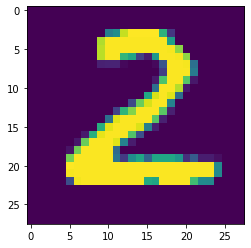

In [390]:
idx = np.random.randint(0, len(test_set)-1)
data, target = test_set[idx]
plt.imshow(data[0])
print('Target: {}, Estimation: {}'.format(target, result[idx]))

# Detection and Refinement

In [345]:
from sklearn import svm

refinement_loader =  DataLoader(x_train_set_2, 4096, shuffle=False)
clf = svm.OneClassSVM(nu=0.02, kernel="rbf", gamma=0.1)

result = None
Q.eval()
with torch.no_grad():
    for inputs, _ in refinement_loader:
        inputs = inputs.flatten(1).to(device)
        z = Q(inputs)
        if result is not None:
            result = torch.cat([result, z], dim=0)
        else:
            result = z
    

In [346]:
clf.fit(result.cpu())

OneClassSVM(gamma=0.1, nu=0.02)

In [347]:
asd = clf.predict(result.cpu())

In [348]:
print(np.where(asd==-1)[0].shape)

(364,)


In [349]:
idx = torch.tensor(np.where(asd==-1)).flatten()
two = 0
for i in idx:
    if x_train_set[i][1] == 2:
        two += 1

print(two)

24


In [350]:
normal_idx = torch.where((torch.tensor(asd) == 1))[0]
x_train_set_2 = Subset(x_train_set, normal_idx)
train_loader =  DataLoader(x_train_set_2, 128, shuffle=True)
# normal_idx = torch.where((torch.tensor(asd) == 1))[0]
# print(anomaly_idx)

In [351]:
len(x_train_set_2)

5651